# Phase 1: Introduction to the Project & Dataset Exploration

### Brief Description of the Dataset:

Link to the Dataset: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia

#### <u>The dataset is comprised of 3 folders:<u>

1. **train** - *contains the images that the model will be trained on* (the training set)
   - **1341 images** are x-rays of **'normal'** lungs, **3875 images** are x-rays of lungs with **pneumonia**
2. **test** - *contains the images that the model will be tested on to evaluate its performance, providing guidelines for model tuning* (the test set)
   - **234 images** are x-rays of **'normal'** lungs, **390 images** are x-rays of lungs with **pneumonia**
3. **val** - *contains the images that will be used to assess the final performance of the fully trained model* (the validation set)
   - **8 images** are x-rays of **'normal'** lungs, **8 images** are x-rays of lungs with **pneumonia**

The dataset contains images of lungs with both 'bacterial' and 'viral' pneumonia, however the model will not differentiate between the two (it will simply aim to classify a given x-ray image of a lung as being infected with pneumonia or not).

### **Pointing out the class imbalance**
With a total of 5216 images in the training set, roughly **74.3%** of the images in the training set are **x-ray images of pneumonia-infected lungs**, leaving ***only around 25.7%*** of the images in the training set to be ***x-ray images of healthy lungs***. **This is quite a significant class imbalance** (almost 3x as many pneumonia infected lungs as healthy lungs) and this will need to be handled later on.

# Phase 2: Data Preprocessing

### Importing Tensorflow & the ImageDataGenerator Class

In [1]:
import tensorflow
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## 1. Preprocessing the Training Set

In [2]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.


Keras' *flow_from_directory* expects a directory structure whereby the main directory (which is passed in as the first parameter) contains **subdirectories** for each class, which is how this dataset is structured. Images are then assigned a label according to the folder name (due to alphabetical order, images in 'NORMAL' are assigned 0, images in 'PNEUMONIA' are assigned 1)

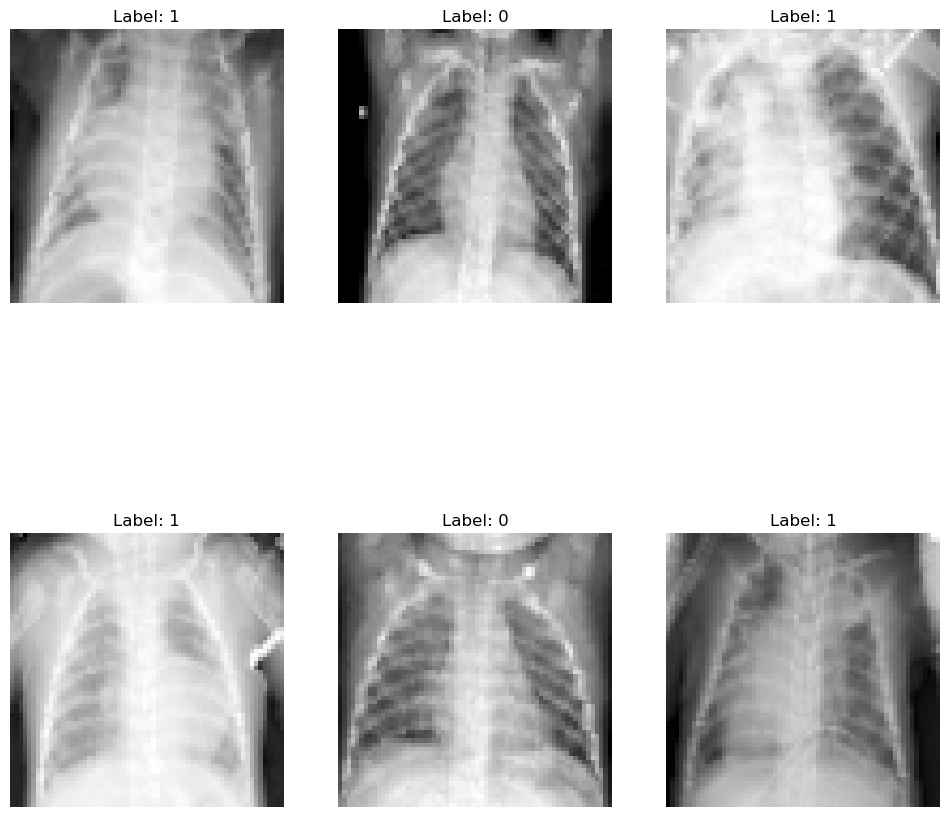

In [3]:
import matplotlib.pyplot as plt

images, labels = next(training_set)

plt.figure(figsize=(12, 12))
for i in range(6):
    plt.subplot(2, 3, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(f"Label: {int(labels[i])}") #0 for normal, 1 for pneumonia
    plt.axis("off")
plt.show()

## 2. Preprocessing the Test Set

The test set should **not be augmented** because it should reflect *real-world conditions*, the model would be tested on **altered images** that aren't actual medical scans

In [4]:
test_datagen = ImageDataGenerator(rescale=1.0/255.0)

test_set = test_datagen.flow_from_directory('data/test',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

Found 624 images belonging to 2 classes.


#### Handling the Class Imbalance: Using Class Weighting instead of Resampling techniques

Since the class imbalance is not too extreme, and resampling (over/undersampling) can lead to overfitting/loss of valuable information, I will proceed with *cost-sensitive learning*, by using sklearn's **compute_class_weight** function

In [5]:
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

class_labels = np.array([0,1]) #(0 = Normal, 1 = Pneumonia)

class_weights = compute_class_weight(
    class_weight = "balanced",
    classes = class_labels,
    y = [0]*1341 + [1]*3875)

class_weight_dict = {i: weight for i, weight in enumerate(class_weights)}
print("Computed Class Weights:", class_weight_dict)

Computed Class Weights: {0: 1.9448173005219984, 1: 0.6730322580645162}


The CNN model to be built calculates a **loss function** which the model aims to minimize throughout subsequent epocs. With class weighting, the loss function applies **higher penalties** to misclassified samples from the *minority class* (which are the normal lungs). This handles the class imbalance by urging the model to pay more attention to the minority class (normal lungs).

# Phase 3: Model Development

In [6]:
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.models import Sequential

### 1. Convolution

In [7]:
cnn = Sequential()

In [8]:
cnn.add(Conv2D(filters=32,
               kernel_size=3,
               activation='relu',
               input_shape=(64,64,1)))

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


### 2. Pooling

In [9]:
cnn.add(MaxPool2D(pool_size=2,
                  strides=2))

**Multiple convolution layers may be added to make the architecture more complex** - This is needed since detecting pneumonia in grayscale x-ray images is already very difficult for the human eye: The more difficult it is to detect certain the features, the greater the need for a more complex model.

In [10]:
#Second Layer:
cnn.add(Conv2D(filters=32,
                 kernel_size=3,
                 activation='relu'))

cnn.add(MaxPool2D(pool_size=2,
                  strides=2))

#Third Layer:
cnn.add(Conv2D(filters=32,
                 kernel_size=3,
                 activation='relu'))

cnn.add(MaxPool2D(pool_size=2,
                  strides=2))

### 3. Flattening

In [11]:
cnn.add(Flatten())

### 4. Full Connection

In [12]:
cnn.add(Dense(units=128,
              activation='relu'))

#final output layer
cnn.add(Dense(units=1,
              activation='sigmoid'))

In [13]:
from tensorflow.keras.metrics import Precision, Recall
cnn.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])

In [14]:
history = cnn.fit(x=training_set, validation_data=test_set, epochs=10, class_weight = class_weight_dict)

/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 153ms/step - accuracy: 0.5918 - loss: 0.5650 - precision: 0.8789 - recall: 0.5018 - val_accuracy: 0.7933 - val_loss: 0.4299 - val_precision: 0.9454 - val_recall: 0.7103
Epoch 2/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 152ms/step - accuracy: 0.8787 - loss: 0.2849 - precision: 0.9585 - recall: 0.8737 - val_accuracy: 0.8718 - val_loss: 0.2987 - val_precision: 0.9101 - val_recall: 0.8821
Epoch 3/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 153ms/step - accuracy: 0.9018 - loss: 0.2540 - precision: 0.9699 - recall: 0.8963 - val_accuracy: 0.8942 - val_loss: 0.2840 - val_precision: 0.8951 - val_recall: 0.9410
Epoch 4/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 163ms/step - accuracy: 0.9172 - loss: 0.2040 - precision: 0.9731 - recall: 0.9119 - val_accuracy: 0.8798 - val_loss: 0.3254 - val_precision: 0.8759 - val_recall: 0.9410
Epoch 5/10
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.9216 - loss: 0.2052 - precision: 0.9761 - recall: 0.9172 - val_accuracy: 0.8894

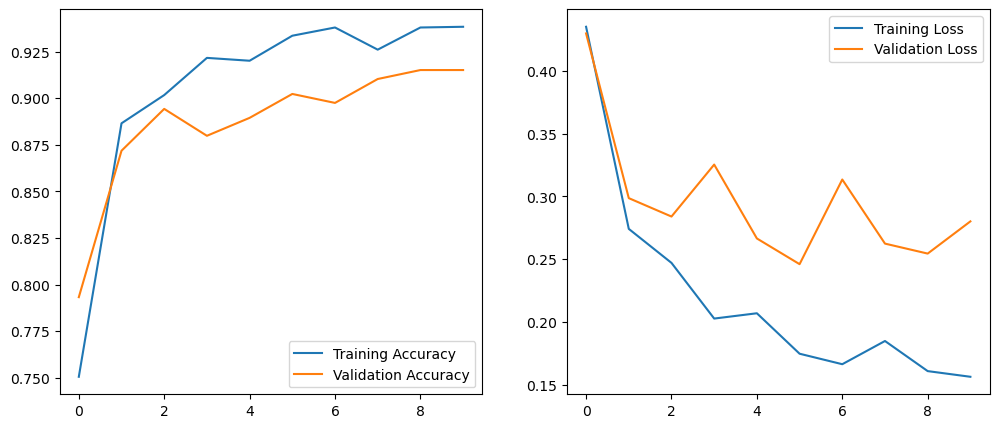

In [15]:
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

There are relatively erratic fluctuations in validation loss. While the fluctuations are not too significant in number, there is no 
clear downward trend: The model is clearly struggling to generalize.

The model also seems to be overfitting due to **lower validation accuracy** than training accuracy, as well as **higher validation loss** than training loss

### Precision Metrics

In [16]:
print("Training Precision:", history.history['precision'], '\n')
print("Validation Precision:", history.history['val_precision'], '\n')

Training Precision: [0.9318792223930359, 0.9581356644630432, 0.9692909121513367, 0.9750548005104065, 0.9744786024093628, 0.979347825050354, 0.982079803943634, 0.9775527119636536, 0.9792172908782959, 0.9792284965515137] 

Validation Precision: [0.9453924894332886, 0.9100528955459595, 0.8951219320297241, 0.8758949637413025, 0.9234828352928162, 0.9061728119850159, 0.8687782883644104, 0.9217171669006348, 0.9099756479263306, 0.9099756479263306] 



The model seems to be **slightly weak** at minimizing false positives when it comes to unseen data (validation precision is quite significantly lower than training precision across all epochs)

### Recall Metrics

In [17]:
print("Training Recall:", history.history['recall'], '\n')
print("Validation Recall:", history.history['val_recall'], '\n')

Training Recall: [0.7166451811790466, 0.8859354853630066, 0.8960000276565552, 0.9179354906082153, 0.9163870811462402, 0.9300644993782043, 0.9334193468093872, 0.9215483665466309, 0.93625807762146, 0.9367741942405701] 

Validation Recall: [0.7102563977241516, 0.8820512890815735, 0.9410256147384644, 0.9410256147384644, 0.8974359035491943, 0.9410256147384644, 0.9846153855323792, 0.9358974099159241, 0.9589743614196777, 0.9589743614196777] 



The model seems to be **relatively strong** at detecting actual pneumonia cases when it comes to unseen data

## Model Tuning

### Trying a lower learning rate

In [18]:
#default learning rate of adam optimizer is 0.001, try 0.0005
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(learning_rate=0.0005)

cnn.compile(optimizer = adam_optimizer, loss = 'binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
history = cnn.fit(x=training_set, validation_data=test_set, epochs=15, class_weight=class_weight_dict)

Epoch 1/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 27s 162ms/step - accuracy: 0.9346 - loss: 0.1652 - precision: 0.9798 - recall: 0.9320 - val_accuracy: 0.9167 - val_loss: 0.2635 - val_precision: 0.9102 - val_recall: 0.9615
Epoch 2/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.9440 - loss: 0.1535 - precision: 0.9814 - recall: 0.9424 - val_accuracy: 0.9199 - val_loss: 0.2522 - val_precision: 0.9087 - val_recall: 0.9692
Epoch 3/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.9495 - loss: 0.1460 - precision: 0.9853 - recall: 0.9453 - val_accuracy: 0.9263 - val_loss: 0.2425 - val_precision: 0.9257 - val_recall: 0.9590
Epoch 4/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.9475 - loss: 0.1439 - precision: 0.9837 - recall: 0.9459 - val_accuracy: 0.9279 - val_loss: 0.2255 - val_precision: 0.9302 - val_recall: 0.9564
Epoch 5/15
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.9444 - loss: 0.1458 - precision: 0.9839 - recall: 0.9398 - val_accuracy: 0.9183

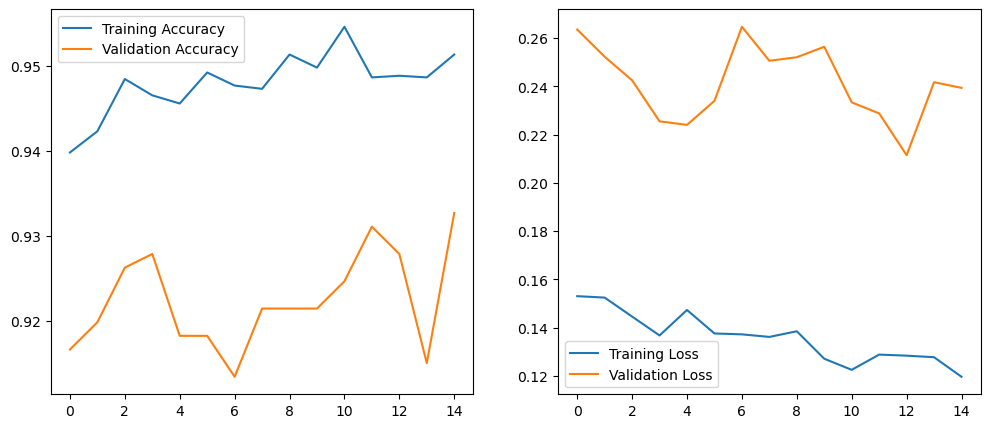

In [19]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

There are slight upward/downward trends in validation accuracy/loss respectively, however there are still erratic fluctuations - **slight improvement nonetheless**

This may suggest batch sensitivity and/or model instability - overall this shows the model is still inconsistent. Additionally, the model is still overfitting due to the significant difference between training and validation accuracy/loss

### Trying a larger batch size

In [20]:
#Try larger batch size
training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (64,64),
                                                 batch_size = 64,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('data/test',
                                                 target_size = (64,64),
                                                 batch_size = 64,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

cnn.compile(optimizer = adam_optimizer, loss = 'binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
history = cnn.fit(x=training_set, validation_data=test_set, epochs=15, class_weight=class_weight_dict)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Epoch 1/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 27s 320ms/step - accuracy: 0.9533 - loss: 0.1095 - precision: 0.9884 - recall: 0.9484 - val_accuracy: 0.9199 - val_loss: 0.2655 - val_precision: 0.9028 - val_recall: 0.9769
Epoch 2/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 26s 313ms/step - accuracy: 0.9530 - loss: 0.1172 - precision: 0.9864 - recall: 0.9491 - val_accuracy: 0.9215 - val_loss: 0.3013 - val_precision: 0.9031 - val_recall: 0.9795
Epoch 3/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - accuracy: 0.9490 - loss: 0.1193 - precision: 0.9812 - recall: 0.9485 - val_accuracy: 0.9295 - val_loss: 0.2445 - val_precision: 0.9199 - val_recall: 0.9718
Epoch 4/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 26s 312ms/step - accuracy: 0.9563 - loss: 0.1138 - precision: 0.9871 - recall: 0.9530 - val_accuracy: 0.9279 - val_loss: 0.2444 - val_precision: 0.9177 - val_recall: 0.9718
Epoch 5/15
82/82 ━━━━━━━━━━━━━━━━━━━━ 26s 316ms/step - accuracy: 0.9585 -

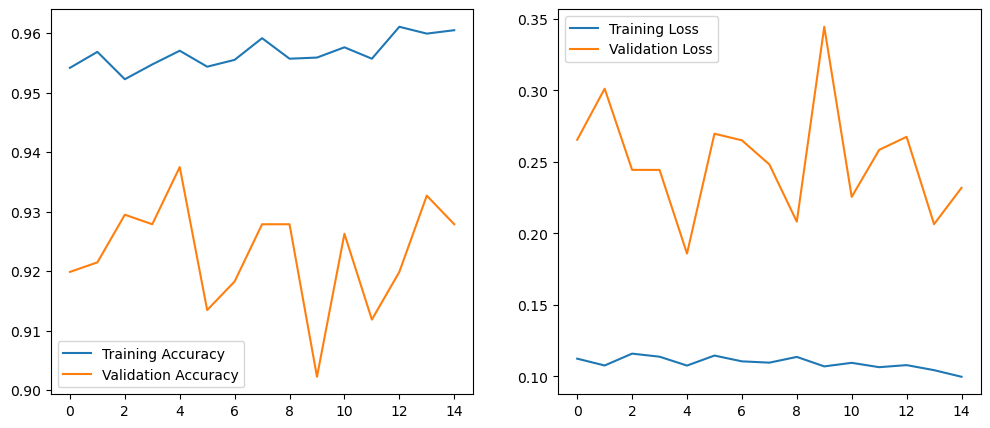

In [21]:
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

Model seems even more unstable: This may have occured since larger batch sizes lead to **less frequent weight updates** (the model's weights update after each batch, therefore larger bathces means fewer batches = fewer updates)

In [22]:
#Reducing batch size back to 32
training_set = train_datagen.flow_from_directory('data/train',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

test_set = test_datagen.flow_from_directory('data/test',
                                                 target_size = (64,64),
                                                 batch_size = 32,
                                                 color_mode = 'grayscale',
                                                 class_mode = 'binary')

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


### Trying an even lower learning rate and introducing early stopping and L2 regularization

In [7]:
#Try lower learning rate + modify Early Stopping
from tensorflow.keras.optimizers import Adam
adam_optimizer = Adam(learning_rate=0.0003) #0.0005 --> 0.0003

from tensorflow.keras.callbacks import EarlyStopping
early_stop = EarlyStopping(monitor='val_loss', patience=4, restore_best_weights=True) #Stop after 4 rounds

In [8]:
#Redefining model architecture with Regularization
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.regularizers import l2

cnn = Sequential()

# First Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001), input_shape=(64, 64, 1)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Second Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Third Convolutional Layer
cnn.add(Conv2D(32, kernel_size=3, activation='relu', kernel_regularizer=l2(0.001)))
cnn.add(MaxPool2D(pool_size=2, strides=2))

# Flatten layer
cnn.add(Flatten())

# Fully Connected Layer
cnn.add(Dense(units=128, activation='relu'))

#Output Layer
cnn.add(Dense(units=1, activation='sigmoid'))

cnn.compile(optimizer=adam_optimizer, loss='binary_crossentropy', metrics=['accuracy', Precision(name='precision'), Recall(name='recall')])
cnn.fit(x=training_set, validation_data=test_set, epochs=20, class_weight=class_weight_dict, callbacks=[early_stop])

/opt/anaconda3/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/opt/anaconda3/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 156ms/step - accuracy: 0.6089 - loss: 0.6907 - precision: 0.8310 - recall: 0.5983 - val_accuracy: 0.7997 - val_loss: 0.4700 - val_precision: 0.9431 - val_recall: 0.7231
Epoch 2/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 25s 151ms/step - accuracy: 0.8538 - loss: 0.3601 - precision: 0.9531 - recall: 0.8442 - val_accuracy: 0.8333 - val_loss: 0.4070 - val_precision: 0.9281 - val_recall: 0.7949
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 157ms/step - accuracy: 0.8937 - loss: 0.2929 - precision: 0.9620 - recall: 0.8927 - val_accuracy: 0.8333 - val_loss: 0.3965 - val_precision: 0.9307 - val_recall: 0.7923
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 158ms/step - accuracy: 0.8914 - loss: 0.2852 - precision: 0.9651 - recall: 0.8849 - val_accuracy: 0.7933 - val_loss: 0.4677 - val_precision: 0.9579 - val_recall: 0.7000
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 26s 159ms/step - accuracy: 0.8921 - loss: 0.2830 - precision: 0.9674 - recall: 0.8830 - val_accuracy: 0.8878

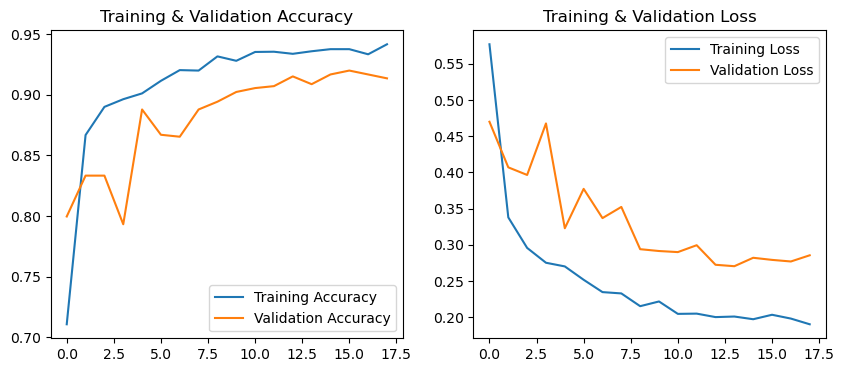

In [9]:
history = cnn.history
epochs = range(len(history.history['accuracy']))

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, history.history['accuracy'], label='Training Accuracy')
plt.plot(epochs, history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs, history.history['loss'], label='Training Loss')
plt.plot(epochs, history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Training & Validation Loss')

plt.show()

**Significant improvement**. Model looks more stable (although there are still some erratic changes in validation accuracy/loss), less overfitting (smaller difference betweeen train and validation accuracy) and there are clear upward/downward trends for validation accuracy/loss respectively.

In [10]:
print("Training Precision:", history.history['precision'], '\n')
print("Validation Precision:", history.history['val_precision'], '\n')

print("Training Recall:", history.history['recall'], '\n')
print("Validation Recall:", history.history['val_recall'], '\n')

Training Precision: [0.9043388962745667, 0.9561101794242859, 0.9614201784133911, 0.9669467806816101, 0.9684797525405884, 0.9697219729423523, 0.9755292534828186, 0.9744715690612793, 0.9782490730285645, 0.9773533344268799, 0.9814864993095398, 0.9796637892723083, 0.9803975224494934, 0.9783783555030823, 0.9794650077819824, 0.9792060256004333, 0.9790817499160767, 0.9793233275413513] 

Validation Precision: [0.9431437849998474, 0.9281437397003174, 0.9307228922843933, 0.9578947424888611, 0.9081632494926453, 0.8373626470565796, 0.9297752976417542, 0.8619909286499023, 0.921875, 0.910224437713623, 0.9211195707321167, 0.9029126167297363, 0.9099756479263306, 0.9215189814567566, 0.9121951460838318, 0.9066985845565796, 0.9267676472663879, 0.9097561240196228] 

Training Recall: [0.6830967664718628, 0.8601290583610535, 0.8874838948249817, 0.8908386826515198, 0.8960000276565552, 0.9091612696647644, 0.9156128764152527, 0.9161290526390076, 0.928516149520874, 0.9243870973587036, 0.9303225874900818, 0.9323

### Introducing a Dropout Layer

## Making a Single Prediction

In [19]:
from keras.preprocessing import image

img = image.load_img('data/val/NORMAL/NORMAL2-IM-1442-0001.jpeg', target_size=(64, 64), color_mode='grayscale')
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = img_array / 255.0

prediction = cnn.predict(img_array)
class_label = "Pneumonia" if prediction > 0.5 else "Normal"

print(f"Prediction: {class_label} (Confidence: {prediction[0][0]:.4f})")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
Prediction: Normal (Confidence: 0.0154)


- Model Predicts 5/8 Normal Lungs **correctly** in the Validation Set
- Model Predicts 8/8 Pneumonia Lungs **correctly** in the Validation Set

## Saving the model

In [20]:
cnn.save("../../web-app/david-boules/model.keras")

# References:

- Data Augmentation Techniques: https://www.linkedin.com/advice/0/how-do-you-implement-data-augmentation-techniques
- Handling Class Imbalance in Image Classification: Techniques and Best Practices: https://medium.com/@okeshakarunarathne/handling-class-imbalance-in-image-classification-techniques-and-best-practices-c539214440b0
- Handling Class Imbalances using Class Weights: https://medium.com/@ravi.abhinav4/improving-class-imbalance-with-class-weights-in-machine-learning-af072fdd4aa4
- The Ultimate Guide to Convolutional Neural Networks: https://www.superdatascience.com/blogs/the-ultimate-guide-to-convolutional-neural-networks-cnn
- Building a Convolutional Neural Network using TensorFlow: https://www.analyticsvidhya.com/blog/2021/06/building-a-convolutional-neural-network-using-tensorflow-keras/
- Fixing Overfitting on a CNN: https://www.geeksforgeeks.org/what-are-the-possible-approaches-to-fixing-overfitting-on-a-cnn/
- Regularization in Deep Learning: https://www.analyticsvidhya.com/blog/2018/04/fundamentals-deep-learning-regularization-techniques/